In [ ]:
import sys

print(sys.version)
print(*sys.path, sep='\n')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'  # use CPU for testing. GPU doesn't have inf and nan. It could overflow.
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [4]:
# parameters for trained CNN
root = os.path.join('.', 'dataset_root')
model_path = os.path.join('.', 'mnist_simple_full.pt')
# mean, std = [0.13066046], [0.30150425] # based on training set
BATCH_SIZE = 16
NUM_CLASSES = 10

In [5]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [6]:
# prepare data
# foolbox model expects raw numpy array as image
# NOTE: the normalize function put range to [-.4, 2.8]! NO!
# https://developers.google.com/machine-learning/data-prep/transform/normalization
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)
])

test_dataset = tv.datasets.MNIST(
    root,
    train=False, 
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers
)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(int(((28 - (3-1)) / 2)**2 * 8), 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [8]:
def validate(model, loader):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            loss = F.nll_loss(output, y)
            total_loss += loss.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [9]:
# NOTE: NO GPU AT SCHOOL!
model = Net()
model_softmax = torch.nn.Sequential(
    model,
    torch.nn.LogSoftmax(dim=1)
)

In [10]:
# load trained parameters
# this will load both models
model_softmax.load_state_dict(torch.load(model_path, map_location=device))
model_softmax.to(device)
model.eval()
model_softmax.eval()

Sequential(
  (0): Net(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (fc1): Linear(in_features=1352, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (1): LogSoftmax()
)

In [11]:
print(len(test_loader.dataset))
va_loss, va_acc = validate(model_softmax, test_loader)
print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

10000
Test Loss: 0.0753 Accuracy: 97.6600%


In [12]:
# Same accuracy as softmax model, this proves the model has trained parameters
# The loss function is way off, which is expected.
print(len(test_loader.dataset))
va_loss, va_acc = validate(model, test_loader)
print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

10000
Test Loss: -14.7493 Accuracy: 97.6600%


In [13]:
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)
batch_size, c, h, w = images.size()
print(batch_size, c, h, w)

16 1 28 28


In [14]:
outputs = model(images)
preds = outputs.max(1, keepdim=True)[1]
print(preds)

tensor([[9],
        [0],
        [2],
        [4],
        [2],
        [7],
        [7],
        [2],
        [4],
        [5],
        [1],
        [1],
        [1],
        [4],
        [6],
        [7]], device='cuda:0')


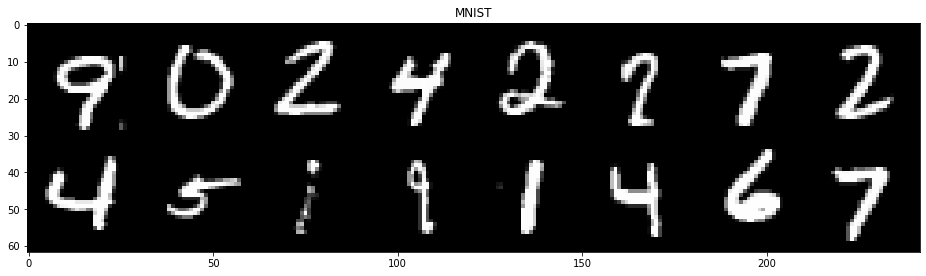

9, 0, 2, 4, 2, 7, 7, 2, 4, 5, 1, 9, 1, 4, 6, 7


In [15]:
plt.figure(figsize=[16, 6])
imshow(images.cpu().detach(), title='MNIST')
plt.show()
print(*labels.cpu().detach().numpy(), sep=', ')

In [16]:
print(images.mean(), images.max(), images.min(), images.mean(), images.std())

tensor(0.1212, device='cuda:0') tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0.1212, device='cuda:0') tensor(0.2983, device='cuda:0')


In [17]:
# parameters for C&W L2 attack
BINARY_SEARCH_STEPS = 9           # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000            # number of iterations to perform gradient descent
ABORT_EARLY = True                # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2              # larger values converge faster to less accurate results
TARGETED = False                  # should we target one specific class? or just be wrong?
CONFIDENCE = 0                    # how strong the adversarial example should be, kappa in the paper
INITIAL_C_MULTIPLIER = 1e-3       # the initial constant c_multiplier to pick as a first guess
C_RANGE = [0, 1e10]            # lower and upper bounds for c_multiplier
# NOTE: the normalize function does NOT scale the range to -1, 1.
BOX_BOUND = [0., 1.]              # [-1., 1.] is used in original paper
# NOTE: np.inf will return nan when np.inf*0. This is a problem!
INF = 1e10                        # np.inf does NOT play well with pytorch. 1e10 was used in carlini's implementation

In [18]:
def arctanh(x, epsilon=1e-6):
    '''
    formular:
    https://en.wikipedia.org/wiki/Inverse_hyperbolic_functions#Inverse_hyperbolic_tangent
    '''
    assert isinstance(x, torch.Tensor), f'{type(x)} is not a torch.Tensor!'

    x = x * (1-epsilon)  # to enhance numeric stability. avoiding devide by zero
    return 0.5 * torch.log((1.+x) / (1.-x))

In [19]:
def to_tanh_sapce(image, bound=BOX_BOUND):
    box_mul = (bound[1] - bound[0]) * .5
    box_plus = (bound[1] + bound[0]) * .5
    return arctanh((image - box_plus) / box_mul)

In [20]:
def from_tanh_space(w, bound=BOX_BOUND):
    box_mul = (bound[1] - bound[0]) * .5
    box_plus = (bound[1] + bound[0]) * .5
    return torch.tanh(w)*box_mul + box_plus

In [21]:
def one_hot_encoding(labels, num_classes):
    assert isinstance(labels, torch.Tensor), \
        f'{type(labels)} is not a torch.Tensor!'
    assert labels.max().item() < num_classes, \
        f'Invalid label {labels.max()} > {num_classes}'
    
    labels_t = labels.unsqueeze(1)
    y_onehot = torch.zeros(len(labels), num_classes, dtype=torch.int8)
    y_onehot = y_onehot.to(device)
    return y_onehot.scatter_(1, labels_t, 1)

In [22]:
def get_l2_norm(x, y):
    assert isinstance(x, torch.Tensor)
    assert isinstance(y, torch.Tensor)
    assert x.size() == y.size()
    
    b = x.size(0)
    return torch.sum(torch.pow(x - y, 2).view(b, -1), 1)

In [23]:
# We want all adversarial examples to be classified as 3
if TARGETED:
    targets = torch.ones(batch_size, dtype=torch.long) * 3
    print('targets size: {}, dtype: {} , grid: {}'.format(
        targets.size(),
        targets.dtype,
        targets.requires_grad))
else: 
    targets = labels  # for untargeted attack, targets are same as labels. 

In [24]:
# For constant c
# set the lower and upper bounds accordingly
# lower_bound <= c_multiplier <= upper_bound
# each image inside one batch may have varied c value
# https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
# Line 163: lower = 0, initial = 1e-3, upper = 1e10
lower_bounds = np.ones(batch_size, dtype=np.float32) * C_RANGE[0]             # lower bound for c
c_multipliers = np.ones(batch_size, dtype=np.float32) * INITIAL_C_MULTIPLIER  # current c
upper_bounds = np.ones(batch_size, dtype=np.float32) * C_RANGE[1]             # upper bound for c

In [25]:
# overall score
o_best_l2 = np.ones(batch_size, dtype=np.float32) * INF  # overall least L2 norms. Set to infinity at start
o_best_pred = -np.ones(batch_size, dtype=np.float32)    # the perturbed predictions with the least L2 norms. Set to -1, since no class is matched.
o_best_adv = torch.zeros_like(images)
print(o_best_adv.size())

torch.Size([16, 1, 28, 28])


In [26]:
inputs_tanh = to_tanh_sapce(images)
print('inputs_tanh size: {}, dtype: {} , grid: {}'.format(
    inputs_tanh.size(), inputs_tanh.dtype, inputs_tanh.requires_grad))

inputs_tanh size: torch.Size([16, 1, 28, 28]), dtype: torch.float32 , grid: False


In [27]:
targets_onehot = one_hot_encoding(targets, num_classes=NUM_CLASSES)
print('targets size: {}, dtype: {} , grid: {}'.format(
    targets.size(), targets.dtype, targets.requires_grad))
print(targets_onehot)

targets size: torch.Size([16]), dtype: torch.int64 , grid: False
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], device='cuda:0', dtype=torch.int8)


In [28]:
# the perturbation variable to optimize
# `pert_tanh` is the adversarial examples in tanh-space, it is refered as w_i in the paper
# In Carlini's code it's denoted as `modifier`
pert_tanh = torch.zeros_like(images, requires_grad=True)
print('pert_tanh size: {}, dtype: {} , grid: {}'.format(
    pert_tanh.size(), pert_tanh.dtype, pert_tanh.requires_grad))

pert_tanh size: torch.Size([16, 1, 28, 28]), dtype: torch.float32 , grid: True


In [29]:
# Adam with learning rate 0.01 is used in the paper
optimizer = torch.optim.Adam([pert_tanh], lr=LEARNING_RATE)

In [30]:
def optimize(model, optimizer, inputs_tanh, pert_tanh, targets_oh, c):
    # NOTE: `targets_oh` could be 2 different variables
    #       1. the true label for original image on untargeted attacks
    #       2. the target class for targeted attacks
    
    # targets_oh (batch, classes): (8, 10)
    
    optimizer.zero_grad()
    
    # adversarial examples
    new_imgs = from_tanh_space(inputs_tanh + pert_tanh)  # the trained model does not known tanh-space
    pred_outputs = model(new_imgs)  # predictions from adversarial examples BEFORE SOFTMAX
    # pred_outputs (batch, classes): (8, 10)
    
    inputs = from_tanh_space(inputs_tanh)
    l2_norms = get_l2_norm(inputs, new_imgs)  # the L2 distance is measured in image-sapce
    
    # only keeps the output for the target class
    target_output = torch.sum(targets_oh*pred_outputs, 1)
    # this returns the max output exclude the target label
    other_output = torch.max((1-targets_oh)*pred_outputs - targets_oh*INF, 1)[0]
    
    if TARGETED:
        f_loss = torch.clamp(other_output - target_output + CONFIDENCE, min=0.)
    else:  # untargeted, the target variable is the true class
        f_loss = torch.clamp(target_output - other_output + CONFIDENCE, min=0.)
    
    # sum up the batch into 1 total loss
    # gradient can only be created only for scalar outputs
    loss = torch.sum(l2_norms + c*f_loss)
    
    # optimization step
    loss.backward()
    optimizer.step()
    
    return loss, l2_norms, pred_outputs, new_imgs

In [31]:
def compensate_confidence(outputs, targets):
    assert type(outputs) == np.ndarray
    assert type(targets) == np.ndarray
    
    outputs_comp = np.copy(outputs)
    
    if TARGETED:
        outputs_comp[np.arange(targets.shape[0]), targets] -= CONFIDENCE
    else:
        outputs_comp[np.arange(targets.shape[0]), targets] += CONFIDENCE
    
    return outputs_comp

In [32]:
def does_attack_success(pred, label):
    if TARGETED:  
        return pred == label  # match the target label
    else:
        return pred != label  # anyting other than the ture label

In [33]:
# `repeat` guarantees at least attempt the largest `c_multiplier` once.
# the larger `c_multiplier` becomes, the easier to find adversarial.
# If `c_multiplier` = 0, there will be no perturbation, and x' = x.
binary_search_steps = BINARY_SEARCH_STEPS
repeat = binary_search_steps >= 10

# search for constant
for sstep in range(BINARY_SEARCH_STEPS):
    if repeat and sstep == binary_search_steps - 1:
        c_multipliers = upper_bounds
    
    c = torch.from_numpy(c_multipliers)
    c = c.to(device)
    print(f'c: {c_multipliers}')
    
    best_l2 = np.ones(batch_size) * INF  # least L2 norm in current epoch
    best_pred = -np.ones(batch_size)
    
    # previous (summed) batch loss, to be used in early stopping policy
    prev_batch_loss = INF  # type: float
    
    # optimization step
    for ostep in range(MAX_ITERATIONS):
        loss, l2_norms, pred_outputs, adv_egs = optimize(
            model, optimizer, inputs_tanh, pert_tanh, targets_onehot, c)
        
        # print out loss every 10%
        if ostep % (MAX_ITERATIONS//10) == 0:
            print('Step [{}] loss: {:.4f}'.format(
                ostep, loss.cpu().detach().item()))
        
        # abort early strategy
        # check if we should abort search if we're getting nowhere.
        if ABORT_EARLY and ostep % (MAX_ITERATIONS//10) == 0: 
            if loss > prev_batch_loss * (1-1e-4):
                print('abort at [{}/{}] search step [{}/{}] optimize step'.format(
                    sstep, BINARY_SEARCH_STEPS,
                    ostep, MAX_ITERATIONS))
                break
            prev_batch_loss = loss
    
        # update result
        pred_outputs_np = pred_outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()
        
        max_pred_outputs = np.argmax(pred_outputs_np, axis=1)
        comp_pred_outputs = compensate_confidence(pred_outputs_np, targets_np)
        comp_pred_outputs = np.argmax(comp_pred_outputs, axis=1)
        assert comp_pred_outputs.shape == (BATCH_SIZE,), \
            f'comp_pred_outputs.shape = {comp_pred_outputs.shape}'
        
        for i in range(BATCH_SIZE):
            l2 = l2_norms[i]
            pred = comp_pred_outputs[i]
            label = targets_np[i]
            adv_eg = adv_egs[i]  # a tensor
            
            if does_attack_success(pred, label):
                if l2 < best_l2[i]:
                    best_l2[i] = l2
                    best_pred[i] = pred
                if l2 < o_best_l2[i]:
                    o_best_l2[i] = l2
                    o_best_pred[i] = pred
                    o_best_adv[i] = adv_eg
    
    # binary search for c
    for i in range(BATCH_SIZE):
        tlabel = targets_np[i]
        assert best_pred[i] == -1 or does_attack_success(best_pred[i], tlabel)
        assert o_best_pred[i] == -1 or does_attack_success(o_best_pred[i], tlabel)
        
        if best_pred[i] != -1:  # successful, try lower `c` value
            # update upper bound, and divide c by 2
            upper_bounds[i] = min(upper_bounds[i], c_multipliers[i])
            if upper_bounds[i] < 1e9:
                c_multipliers[i] = (lower_bounds[i]+upper_bounds[i]) / 2.
                    
        else:  # failure, try larger `c` value
            # either multiply by 10 if no solution found yet
            # or do binary search with the known upper bound
            lower_bounds[i] = max(lower_bounds[i], c_multipliers[i])
            
            if upper_bounds[i] < C_RANGE[1] * 0.1:  # 1e9 was used in carlini's implementation
                c_multipliers[i] = (lower_bounds[i]+upper_bounds[i]) / 2.
            else:
                c_multipliers[i] *= 10

c: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]
Step [0] loss: 0.1268
Step [1000] loss: 0.1266
Step [2000] loss: 0.1266
Step [3000] loss: 0.1266
Step [4000] loss: 0.1266
abort at [0/9] search step [4000/10000] optimize step
c: [0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 0.01   0.0005 0.01   0.01   0.01   0.01  ]
Step [0] loss: 1.2639
Step [1000] loss: 1.2446
Step [2000] loss: 1.2446
abort at [1/9] search step [2000/10000] optimize step
c: [0.10000001 0.10000001 0.10000001 0.10000001 0.10000001 0.10000001
 0.10000001 0.10000001 0.10000001 0.10000001 0.10000001 0.00025
 0.10000001 0.10000001 0.10000001 0.10000001]
Step [0] loss: 12.2348
Step [1000] loss: 10.5224
Step [2000] loss: 10.5209
Step [3000] loss: 10.5204
abort at [2/9] search step [3000/10000] optimize step
c: [1.0000001e+00 1.0000001e+00 1.0000001e+00 1.0000001e+00 1.0000001e+00
 5.5000003e-02 1.0000001e+00 1.0000001e+00 1.0000001e+00 1.0000001e+00


In [34]:
o_best_l2

array([0.32028434, 6.0002856 , 1.8727444 , 2.26986   , 2.5736256 ,
       0.16219008, 1.2228438 , 2.1738634 , 1.2502908 , 1.0757487 ,
       0.07678357, 0.        , 1.1027181 , 1.9930565 , 1.3434668 ,
       2.1615381 ], dtype=float32)

In [35]:
o_best_pred

array([7., 9., 1., 9., 7., 8., 3., 1., 9., 1., 7., 1., 8., 9., 4., 3.],
      dtype=float32)

In [36]:
o_best_adv.shape

torch.Size([16, 1, 28, 28])

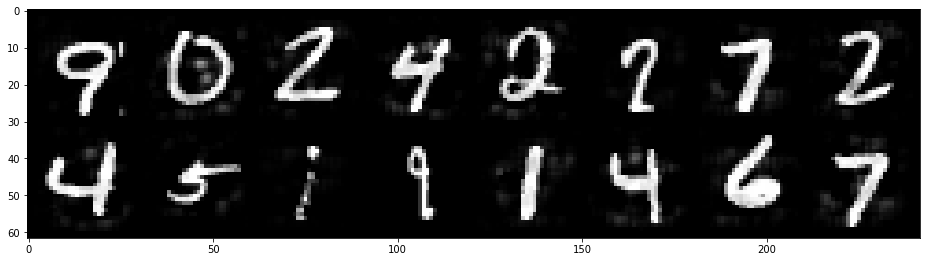

9, 0, 2, 4, 2, 7, 7, 2, 4, 5, 1, 9, 1, 4, 6, 7
7, 9, 1, 9, 7, 8, 3, 2, 9, 1, 7, 1, 8, 9, 4, 3


In [37]:
adv_outputs = model(o_best_adv)
adv_preds = adv_outputs.max(1, keepdim=True)[1]
plt.figure(figsize=[16, 6])
imshow(o_best_adv.cpu().detach())
plt.show()
print(*labels.cpu().detach().numpy(), sep=', ')
print(*adv_preds.squeeze().cpu().detach().numpy(), sep=', ')

3
0.4121694 -0.20595074
(28, 28)


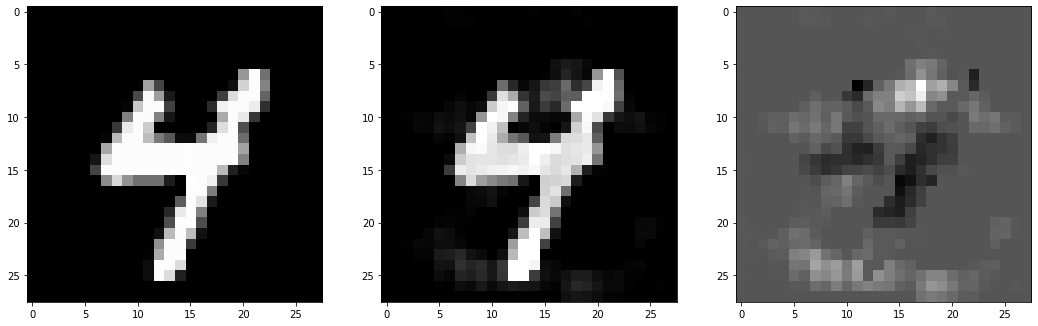

In [38]:
idx = np.random.choice(range(batch_size))
print(idx)
adv = np.squeeze(np.transpose(o_best_adv.cpu().detach().numpy()[idx], (1, 2, 0)))
image = np.squeeze(np.transpose(images.cpu().detach().numpy()[idx], (1, 2, 0)))
p = adv - image
imax = np.max(p)
imin = np.min(p)
print(imax, imin)
p = (p - imin)/ (imax-imin)
print(p.shape)

plt.figure(figsize=[18, 6])
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0., vmax=1.)
plt.subplot(1, 3, 2)
plt.imshow(adv, cmap='gray', vmin=0., vmax=1.)
plt.subplot(1, 3, 3)
plt.imshow(p, cmap='gray', vmin=0., vmax=1.)
plt.show()